<a href="https://colab.research.google.com/github/pglez82/IFCB_semisupervised/blob/master/IFCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Showing system info

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Mon Jun 15 22:41:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.48                 Driver Version: 410.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:17:00.0 Off |                  N/A |
| 23%   29C    P8     9W / 250W |     10MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:65:00.0 Off |                  N/A |
| 52%   79C    P2    88W / 250W |   3147MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

# Download SimCLR code
In this step we download the SimCLR code for **PyTorch** and install its dependencies



In [3]:
import os

if not os.path.isdir("SimCLR"):
  !git clone https://github.com/pglez82/SimCLR.git
 
%cd SimCLR
!sh setup.sh || python3 -m pip install -r requirements.txt || exit 1
!pip install  pyyaml --upgrade

/media/HDD/pgonzalez/IFCB_semisupervised/SimCLR

CondaValueError: prefix already exists: /home/pgonzalez/anaconda3/envs/simclr

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda


Ran pip subprocess with arguments:
['/home/pgonzalez/anaconda3/envs/simclr/bin/python', '-m', 'pip', 'install', '-U', '-r', '/media/HDD/pgonzalez/IFCB_semisupervised/SimCLR/condaenv.zcxll0o0.requirements.txt']
Pip subprocess output:
Requirement already up-to-date: sacred in /home/pgonzalez/anaconda3/envs/simclr/lib/python3.8/site-packages (from -r /media/HDD/pgonzalez/IFCB_semisupervised/SimCLR/condaenv.zcxll0o0.requirements.txt (line 1)) (0.8.1)

#
# To activate this environment, use
#
#     $ conda activate simclr
#
# To deactivate an active environment, use
#
#     $ conda deactivate

Processing /home/pgonzalez/.cache/pip/wheels/5e/03/1e/e1e954795d6f35df

# Download the images
In this section, we **donwload** the data and **uncompress** it. The code has checks in order to ensure that already downloaded data is not redownloaded

In [4]:
%cd ..
if not os.path.isfile("IFCB_data.tar") and not os.path.isdir("data"):
  print("Data do not exist in local. Downloading...")
  !wget -O IFCB_data.tar https://unioviedo-my.sharepoint.com/:u:/g/personal/gonzalezgpablo_uniovi_es/Ec2z0uC4lghEg-9MjzoJ9QkBK5n74QjS-LszB9dlNrPfaw?download=1
else:
  print("Data already exists. Skipping download.")

if not os.path.isdir("data"):
  print("Extracting the tar file...")
  !tar -xf "IFCB_data.tar"
  print("Done. Removing the tar file.")
  !rm -f IFCB_data.tar #Remove the original file to save space

/media/HDD/pgonzalez/IFCB_semisupervised
Data already exists. Skipping download.


# Download CSV with information about the images


In [5]:
import pandas as pd

if not os.path.isfile('IFCB.csv.zip'):
  print("CSV data do not exist. Downloading...")
  !wget -O IFCB.csv.zip "https://unioviedo-my.sharepoint.com/:u:/g/personal/gonzalezgpablo_uniovi_es/EfsVLhFsYJpPjO0KZlpWUq0BU6LaqJ989Re4XzatS9aG4Q?download=1"

data = pd.read_csv('IFCB.csv.zip',compression='infer', header=0,sep=',',quotechar='"')
print(data)

                        Sample  roi_number        OriginalClass  \
0        IFCB1_2006_158_000036           1                  mix   
1        IFCB1_2006_158_000036           2  Tontonia_gracillima   
2        IFCB1_2006_158_000036           3                  mix   
3        IFCB1_2006_158_000036           4                  mix   
4        IFCB1_2006_158_000036           5                  mix   
...                        ...         ...                  ...   
3457814  IFCB5_2014_353_205141        6850       Leptocylindrus   
3457815  IFCB5_2014_353_205141        6852                  mix   
3457816  IFCB5_2014_353_205141        6855                  mix   
3457817  IFCB5_2014_353_205141        6856                  mix   
3457818  IFCB5_2014_353_205141        6857                  mix   

              AutoClass FunctionalGroup  
0                   mix      Flagellate  
1           ciliate_mix         Ciliate  
2                   mix      Flagellate  
3                   mix    

# Create training set

Here we make a reestructuration of the images depending on which class we consider

In [6]:
import progressbar
from tqdm import tqdm

tqdm.pandas()

classcolumn = "AutoClass" #Autoclass means 51 classes
yearstraining = ['2006'] #Years to consider as training
yearsvalidation = ['2007']
trainingfolder = "training"
validationfolder = "validation"

classes = pd.unique(data[classcolumn])
print("Considering %i classes" % len(classes))

print("Computing image paths...")
#Compute data paths
data['year'] = data['Sample'].str[6:10].astype(str)
data['path']="data"+'/'+data['year']+'/'+data['OriginalClass'].astype(str)+'/'+data['Sample'].astype(str)+'_'+data['roi_number'].apply(lambda x: str(x).zfill(5))+'.png'
print('Done')

if not os.path.isdir(trainingfolder):
  print("Create folder structure for training set...")
  os.mkdir(trainingfolder)
  for folder in classes:
    os.mkdir(os.path.join(trainingfolder,folder))
  print("Done.\nMoving images to the respective folders...")
  data[data['year'].isin(yearstraining)].progress_apply(lambda row: os.rename(row['path'],os.path.join(trainingfolder,row[classcolumn],os.path.basename(row['path']))),axis=1)
  print("Done")
else:
  print("Training data already there... Doing nothing")

if not os.path.isdir(validationfolder):
  print("Create folder structure for the validation set...")
  os.mkdir(validationfolder)
  for folder in classes:
    os.mkdir(os.path.join(validationfolder,folder))
  print("Done.\nMoving images to the respective folders...")
  data[data['year'].isin(yearsvalidation)].progress_apply(lambda row: os.rename(row['path'],os.path.join(validationfolder,row[classcolumn],os.path.basename(row['path']))),axis=1)
  print("Done")  
else:
  print("Validation data already there... Doing nothing")


Considering 51 classes
Computing image paths...


/home/pgonzalez/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Done
Training data already there... Doing nothing
Validation data already there... Doing nothing


# Lets configure SimCLR
Number of epocs, optimizer, resnet version to use ...
Things that we have to configure:


*   cuda:0 -> Change to cuda:1 to use second gpu
*   args.batch_size -> higher value its slower but better
*   args.resnet -> resnet18 | resnet50



In [7]:
import torch
from SimCLR.utils.yaml_config_hook import yaml_config_hook
import argparse

config = yaml_config_hook("./SimCLR/config/config.yaml")
args = argparse.Namespace(**config)

#Here we need to select which graphics card we want to use in case of having more than one
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using %s" % args.device)

Using cuda:0


In [27]:
from pprint import pprint
args.dataset = "IFCB" #This value will be used only for the output dir
args.image_size = 128 #@param
args.batch_size =  256 #@param
args.resnet = "resnet18" #@param ['resnet18','resnet50']
#Means that we want to start training in this epoch. We should have a file checkpoint_{}.tar in the args.model_path dir
args.epoch_num =  100 #@param 
#How many epochs we want. If epochs = epoch num we just load the model and do nothing
args.epochs = 100 #@param  
#We want to save the checkpoints to google drive
args.out_dir = "drive/My Drive/Colab Notebooks/{}_{}_b{}_s{}".format(args.dataset,args.resnet,args.batch_size,args.image_size)
args.model_path = args.out_dir #This is the directory from where we want to restore checkpoints
args.proportions = [0.001,0.005,0.01,0.1] #how many labeled data we are going to use for training
args.logistic_epochs = 500

if not os.path.isdir(args.out_dir):
  raise SystemExit("The output folder {} does not exist!".format(args.out_dir))
pprint(vars(args))

{'batch_size': 256,
 'current_epoch': 101,
 'dataset': 'IFCB',
 'device': device(type='cuda', index=0),
 'epoch_num': 100,
 'epochs': 100,
 'fp16': False,
 'fp16_opt_level': 'O2',
 'global_step': 0,
 'image_size': 128,
 'logistic_batch_size': 256,
 'logistic_epochs': 500,
 'model_path': 'drive/My Drive/Colab Notebooks/IFCB_resnet18_b256_s128',
 'normalize': True,
 'optimizer': 'Adam',
 'out_dir': 'drive/My Drive/Colab Notebooks/IFCB_resnet18_b256_s128',
 'pretrain': True,
 'projection_dim': 64,
 'proportions': [0.001, 0.005, 0.01, 0.1],
 'resnet': 'resnet18',
 'seed': 42,
 'start_epoch': 101,
 'temperature': 0.5,
 'weight_decay': 1e-06,
 'workers': 16}


# Loading the training dataset

Use pytorch to load the training dataset

In [9]:
import torchvision
from torchvision import transforms
from SimCLR.modules.transformations import TransformsSimCLR

#This transform makes the magic and returns two augmented images from an original image
train_dataset = torchvision.datasets.ImageFolder(root=trainingfolder, transform=TransformsSimCLR(size=args.image_size))

train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=args.batch_size,
  shuffle=False,
  drop_last=True,
  num_workers=args.workers,
)

# Show some example pictures

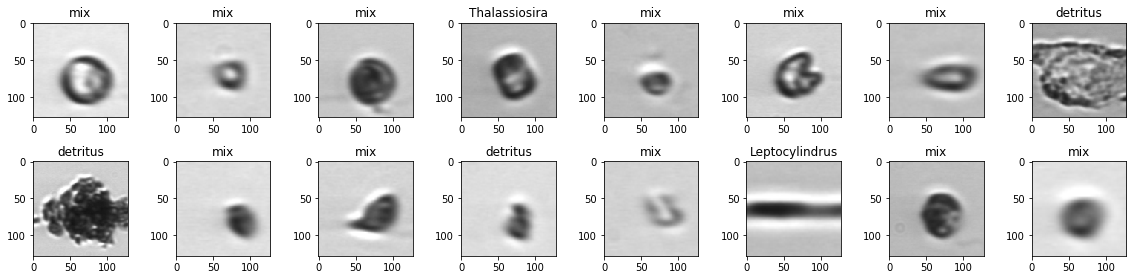

In [10]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
import random

train_dataset_display = torchvision.datasets.ImageFolder(root=trainingfolder,
                                                         transform=T.Compose([T.Resize(size=args.image_size),
                                                                              T.CenterCrop(size=args.image_size)]))
random.seed(35)
fig, axs = plt.subplots(nrows=4, ncols=8, constrained_layout=False, figsize=(16,8))
fig.tight_layout()
for _, ax in enumerate(axs.flat):
  index = random.randint(0, len(train_dataset_display)-1)
  ax.imshow(train_dataset_display[index][0])
  ax.title.set_text(train_dataset_display.classes[train_dataset_display[index][1]])
plt.show()

# Define the training function
This is the function that will do all the work for one epoch

In [11]:
import time

def train(args, train_loader, model, criterion, optimizer, writer):
  loss_epoch = 0
  start_time = time.time()
  for step, ((x_i, x_j), _) in enumerate(train_loader):
    optimizer.zero_grad()
    x_i = x_i.to(args.device)
    x_j = x_j.to(args.device)

    # positive pair, with encoding
    h_i, z_i = model(x_i)
    h_j, z_j = model(x_j)

    loss = criterion(z_i, z_j)

    loss.backward()

    optimizer.step()

    if step % 50 == 0:
      spent = time.time()-start_time
      print(f"Step [{step}/{len(train_loader)}]\t Loss: {loss.item()} \t Time: {spent} secs [{(args.batch_size*50)/spent} ej/sec]]")
      start_time = time.time()

    writer.add_scalar("Loss/Step", loss.item(), args.global_step)
    loss_epoch += loss.item()
    args.global_step += 1

  return loss_epoch

# Load the model
We only reload the model if **args.epoch_num** is different from zero. This case means that we want to continue training from a checkpoint (we should have the model in the **args.model_path** dir.

In [12]:
from SimCLR.model import load_model
model, optimizer, scheduler = load_model(args, train_loader,reload_model=(args.epoch_num!=0))

# Configure TensorBoard



In [13]:
from torch.utils.tensorboard import SummaryWriter

tb_dir = os.path.join(args.out_dir, "colab")
if not os.path.exists(tb_dir):
  os.makedirs(tb_dir)
writer = SummaryWriter(log_dir=tb_dir)

# Load the loss function
This function tries to minimize the difference between the two augmented variations of the image and maximize the difference between these and the rest of the batch

In [14]:
from SimCLR.modules import NT_Xent

criterion = NT_Xent(args.batch_size, args.temperature, args.device)

# Training the CNN
We make a checkpoint each 5 epochs just in case

In [15]:
from SimCLR.model import save_model

args.global_step = 0
if args.epoch_num!=0: #If we have loaded a model trained til an epoch, lets start training in the next
  args.start_epoch=args.epoch_num+1
args.current_epoch = args.start_epoch #Variable for controlling in which epoch we are

for epoch in range(args.start_epoch, args.epochs):
  lr = optimizer.param_groups[0]['lr']
  loss_epoch = train(args, train_loader, model, criterion, optimizer, writer)

  if scheduler:
    scheduler.step()

  if epoch % 5 == 0:
    save_model(args, model, optimizer)

  writer.add_scalar("Loss/train epoch", loss_epoch / len(train_loader), epoch)
  writer.add_scalar("Misc/learning_rate", lr, epoch)
  print(f"Epoch [{epoch+1}/{args.epochs}]\t Loss: {loss_epoch / len(train_loader)}\t lr: {round(lr, 5)}")
  args.current_epoch += 1

## end training
if args.start_epoch!=args.epochs:
  save_model(args, model, optimizer)

In [16]:
#!tensorboard dev upload --logdir "$tb_dir" --name "IFCBv3" --description "Training with 2006 image size 128 batch size 256"

# **Trainining the classifier using the deep features**
Now we will be trying to find out if the network has learnt something useful from the unlabeled data. We will train a Logistic Regression classifier with the labeled examples and testing against a validation dataset

# Define train and test functions

In [17]:
def train(args, loader, model, criterion, optimizer):
  loss_epoch = 0
  accuracy_epoch = 0
  for step, (x, y) in enumerate(loader):
    optimizer.zero_grad()

    x = x.to(args.device)
    y = y.to(args.device)

    output = model(x)
    loss = criterion(output, y)

    predicted = output.argmax(1)
    acc = (predicted == y).sum().item() / y.size(0)
    accuracy_epoch += acc

    loss.backward()
    optimizer.step()

    loss_epoch += loss.item()

  return loss_epoch, accuracy_epoch

In [25]:
def test(args, loader, model, criterion, optimizer):
  loss_epoch = 0
  accuracy_epoch = 0
  y_true = []
  y_pred = []
  model.eval()
  for step, (x, y) in enumerate(loader):
    model.zero_grad()

    x = x.to(args.device)
    y = y.to(args.device)
    
    output = model(x)
    loss = criterion(output, y)

    predicted = output.argmax(1)
    
    #Store predictions so we can build a confusion matrix later
    y_true.extend(y.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())
    
    acc = (predicted == y).sum().item() / y.size(0)
    accuracy_epoch += acc

    loss_epoch += loss.item()

  return loss_epoch, accuracy_epoch,y_true,y_pred

# Load data
We have to load the data again because before the data loader was doing the special agumentation for the contrastive learning. Now we only want to resize the images.




In [19]:
train_dataset = torchvision.datasets.ImageFolder(root=trainingfolder, transform=TransformsSimCLR(size=args.image_size).test_transform,)
test_dataset = torchvision.datasets.ImageFolder(root=validationfolder, transform=TransformsSimCLR(size=args.image_size).test_transform,)

train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=args.logistic_batch_size,
  shuffle=False,
  drop_last=True,
  num_workers=args.workers,
)

test_loader = torch.utils.data.DataLoader(
  test_dataset,
  batch_size=args.logistic_batch_size,
  shuffle=False,
  drop_last=True,
  num_workers=args.workers,
)

In [20]:
def get_labels(data_loader):
  """
  Gets the labels from the 
  """
  labels_vector = []
  for _,y in data_loader:
    labels_vector.extend(y.numpy())
  return labels_vector

def print_class_distribution(labels,class_to_idx):
  class_mapping = {v: k for k, v in class_to_idx.items()}
  df = pd.DataFrame(data=labels)
  df=df.replace(class_mapping)
  c=pd.crosstab(index=df[0],columns='count')
  print(c)


labels_train = get_labels(train_loader)
labels_test = get_labels(test_loader)
print("Printing distribution of training set...")
print_class_distribution(labels_train,train_dataset.class_to_idx)
print("Printing distribution of testing set...")
print_class_distribution(labels_test,test_dataset.class_to_idx)


Printing distribution of training set...
col_0                count
0                         
Asterionellopsis        33
Cerataulina            416
Ceratium                34
Chaetoceros           2187
Corethron               72
Coscinodiscus            9
Cylindrotheca          297
DactFragCerataul       646
Dactyliosolen          135
Dictyocha              115
Dinobryon               90
Dinophysis              23
Ditylum                  4
Ephemera                39
Eucampia                52
Euglena                 98
Gonyaulax                1
Guinardia              634
Guinardia_flaccida       5
Guinardia_striata       43
Gyrodinium              26
Laboea                   6
Lauderia                 1
Leptocylindrus        9818
Licmophora               6
Myrionecta             222
Odontella                1
Paralia                 25
Phaeocystis              1
Pleurosigma             41
Prorocentrum            52
Pseudonitzschia        180
Pyramimonas             44
Rhizosolenia  

# Load de pretrained CNN and its weights

In [21]:
simclr_model, _, _ = load_model(args, train_loader, reload_model=True)
simclr_model = simclr_model.to(args.device)
simclr_model.eval()

SimCLR(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

# Compute deep features for both training and validation sets
Here we use our CNN pretrained using contrastive learning with unlabelled data for computing the features from all the examples.

In [28]:
import numpy as np
from sklearn.model_selection import train_test_split

def create_balanced_splits(labels_vector,proportions):
  """
  This function creates different balanced splits following the proportions
  """
  unique, globalcounts = np.unique(labels_vector, return_counts=True)
  #Find indexes for each class
  classindexes = []
  for c in unique:
    classindexes.append(np.where(labels_vector == c)[0])
  subsets = {}
  for p in proportions:
    subsets[p]=[]
    counts = np.rint(globalcounts*p)
    print("Building subset with %d elements"%sum(counts))
    for i in range(len(counts)):
      subsets[p].extend(classindexes[i][0:int(counts[i])])
  return subsets   

#This function computes the deep features
def inference(loader, context_model, device):
  feature_vector = []
  labels_vector = []
  for step, (x, y) in enumerate(loader):
    x = x.to(device)

    # get encoding
    with torch.no_grad():
      h, z = context_model(x)

    h = h.detach()

    feature_vector.extend(h.cpu().detach().numpy())
    labels_vector.extend(y.numpy())

    if step % 20 == 0:
      print(f"Step [{step}/{len(loader)}]")

  feature_vector = np.array(feature_vector)
  labels_vector = np.array(labels_vector)
  print("Features shape {}".format(feature_vector.shape))
  return feature_vector, labels_vector

def get_features(context_model, train_loader, test_loader, device):
  print("Computing deep features for training set...")
  train_X, train_y = inference(train_loader, context_model, device)
  print("Computing deep features for validation set...")
  test_X, test_y = inference(test_loader, context_model, device)
  return train_X, train_y, test_X, test_y

def create_data_loaders_from_arrays(X_train, y_train, X_test, y_test, batch_size, proportions):
  #We want to create multiple train loaders with different labelled data proportions
  train = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
  train_loader=torch.utils.data.DataLoader(train, batch_size=batch_size)
  indexes = create_balanced_splits(labels_train,args.proportions)
  train_loaders = {}
  for p in args.proportions:
    d=torch.utils.data.Subset(train,indexes[p])
    train_loaders[p]=torch.utils.data.DataLoader(d, batch_size=batch_size, shuffle=True)
  test = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
  test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
  return train_loaders, test_loader

(train_X, train_y, test_X, test_y) = get_features(simclr_model, train_loader, test_loader, args.device)
print("Done")

#We create the data loaders from the arrays with the deep features
arr_train_loaders, arr_test_loader = create_data_loaders_from_arrays(train_X, train_y, test_X, test_y, args.logistic_batch_size,args.proportions)


Computing deep features for training set...
Step [0/511]
Step [20/511]
Step [40/511]
Step [60/511]
Step [80/511]
Step [100/511]
Step [120/511]
Step [140/511]
Step [160/511]
Step [180/511]
Step [200/511]
Step [220/511]
Step [240/511]
Step [260/511]
Step [280/511]
Step [300/511]
Step [320/511]
Step [340/511]
Step [360/511]
Step [380/511]
Step [400/511]
Step [420/511]
Step [440/511]
Step [460/511]
Step [480/511]
Step [500/511]
Features shape (130816, 512)
Computing deep features for validation set...
Step [0/1066]
Step [20/1066]
Step [40/1066]
Step [60/1066]
Step [80/1066]
Step [100/1066]
Step [120/1066]
Step [140/1066]
Step [160/1066]
Step [180/1066]
Step [200/1066]
Step [220/1066]
Step [240/1066]
Step [260/1066]
Step [280/1066]
Step [300/1066]
Step [320/1066]
Step [340/1066]
Step [360/1066]
Step [380/1066]
Step [400/1066]
Step [420/1066]
Step [440/1066]
Step [460/1066]
Step [480/1066]
Step [500/1066]
Step [520/1066]
Step [540/1066]
Step [560/1066]
Step [580/1066]
Step [600/1066]
Step [6

# Lets train the classifier and see how it works!
We are going to train the classifier using different labeled data proportions

In [29]:
from SimCLR.modules import LogisticRegression

for p in args.proportions:
    model = LogisticRegression(simclr_model.n_features, len(classes))
    model = model.to(args.device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    #optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    criterion = torch.nn.CrossEntropyLoss()
    arr_train_loader = arr_train_loaders[p]
    print("Training dataset with proportion %f and %d labeled examples in training set"%(p,len(arr_train_loader)*args.logistic_batch_size))
    for epoch in range(args.logistic_epochs):
        loss_epoch, accuracy_epoch = train(args, arr_train_loader, model, criterion, optimizer)
        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{args.logistic_epochs}]\t Loss: {loss_epoch / len(arr_train_loader)}\t Accuracy: {accuracy_epoch / len(arr_train_loader)}")

    # final testing
    loss_epoch, accuracy_epoch,y_true,y_pred = test(args, arr_test_loader, model, criterion, optimizer)
    #Build the confusion matrix here
    print(f"[FINAL]\t Loss: {loss_epoch / len(arr_test_loader)}\t Accuracy: {accuracy_epoch / len(arr_test_loader)}")

Training dataset with proportion 0.001000 and 256 labeled examples in training set
Epoch [0/500]	 Loss: 4.492379665374756	 Accuracy: 0.0
Epoch [10/500]	 Loss: 3.456709623336792	 Accuracy: 0.3875968992248062
Epoch [20/500]	 Loss: 2.594858169555664	 Accuracy: 0.6821705426356589
Epoch [30/500]	 Loss: 2.0297467708587646	 Accuracy: 0.6821705426356589
Epoch [40/500]	 Loss: 1.7053613662719727	 Accuracy: 0.6821705426356589
Epoch [50/500]	 Loss: 1.4982807636260986	 Accuracy: 0.6821705426356589
Epoch [60/500]	 Loss: 1.3446482419967651	 Accuracy: 0.6821705426356589
Epoch [70/500]	 Loss: 1.2217087745666504	 Accuracy: 0.689922480620155
Epoch [80/500]	 Loss: 1.121346354484558	 Accuracy: 0.689922480620155
Epoch [90/500]	 Loss: 1.0394952297210693	 Accuracy: 0.7441860465116279
Epoch [100/500]	 Loss: 0.9728878736495972	 Accuracy: 0.7906976744186046
Epoch [110/500]	 Loss: 0.9184690713882446	 Accuracy: 0.813953488372093
Epoch [120/500]	 Loss: 0.8735373020172119	 Accuracy: 0.813953488372093
Epoch [130/500]

Epoch [100/500]	 Loss: 0.6211413542429606	 Accuracy: 0.8603645833333333
Epoch [110/500]	 Loss: 0.654225637515386	 Accuracy: 0.8436197916666667
Epoch [120/500]	 Loss: 0.7406692504882812	 Accuracy: 0.8161458333333332
Epoch [130/500]	 Loss: 0.6521889865398407	 Accuracy: 0.8402083333333333
Epoch [140/500]	 Loss: 0.6386792163054148	 Accuracy: 0.8488281249999999
Epoch [150/500]	 Loss: 0.611713300148646	 Accuracy: 0.8602083333333334
Epoch [160/500]	 Loss: 0.5580426057179769	 Accuracy: 0.8694791666666667
Epoch [170/500]	 Loss: 0.547243927915891	 Accuracy: 0.8701302083333333
Epoch [180/500]	 Loss: 0.6130099296569824	 Accuracy: 0.8540364583333333
Epoch [190/500]	 Loss: 0.5846950511137644	 Accuracy: 0.86671875
Epoch [200/500]	 Loss: 0.5316140502691269	 Accuracy: 0.8613541666666666
Epoch [210/500]	 Loss: 0.547229990363121	 Accuracy: 0.8693229166666666
Epoch [220/500]	 Loss: 0.5922094583511353	 Accuracy: 0.8592447916666667
Epoch [230/500]	 Loss: 0.5397707422574362	 Accuracy: 0.872578125
Epoch [240/